In [1]:
import argparse
import torch
from data_provider_pretrain.data_factory import data_provider
from models.time_series_diffusion_model import TimeSeriesDiffusionModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from utils.callbacks import EMA
from lightning.pytorch.loggers import WandbLogger
import time
import random
import numpy as np
import os
import wandb
from datetime import timedelta
from utils.clean_args import clean_args
os.environ['CURL_CA_BUNDLE'] = ''
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

parser = argparse.ArgumentParser(description='Time-LLM')

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
torch.cuda.manual_seed(fix_seed)
torch.cuda.manual_seed_all(fix_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class DotDict(dict):
    """
    A dictionary that supports both dot notation and dictionary access.
    This allows both `args.att` and `args['att']` to work.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__dict__[key] = value

    def __delattr__(self, item):
        self.__dict__.pop(item, None)

default_config = DotDict({
    # Basic config
    "num_nodes": 1,
    "task_name": "long_term_forecast",
    "is_training": 1,
    "model_id": "ETTh1_ETTh2_512_192",
    "model": "ns_Transformer",
    "precision": "32",
    
    # Data loader
    "data_pretrain": "Glucose",
    "root_path": "/home/yl2428/Time-LLM/dataset/glucose",
    "data_path": "combined_data_Jun_28.csv",
    "data_path_pretrain": "combined_data_Jun_28.csv",
    "features": "M",
    "target": "OT",
    "freq": "t",
    "checkpoints": "/gpfs/gibbs/pi/gerstein/yl2428/checkpoints/",
    "log_dir": "/gpfs/gibbs/pi/gerstein/yl2428/logs",
    
    # Forecasting task
    "seq_len": 128,
    "label_len": 12,
    "pred_len": 32,
    "seasonal_patterns": "Monthly",
    "stride": 8,
    
    # Model define
    "enc_in": 4,
    "dec_in": 4,
    "c_out": 4,
    "d_model": 32,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 128,
    "moving_avg": 25,
    "factor": 3,
    "dropout": 0.1,
    "embed": "timeF",
    "activation": "gelu",
    "output_attention": False,
    "patch_len": 16,
    "prompt_domain": 0,
    "llm_model": "LLAMA",
    "llm_dim": 4096,
    
    # Optimization
    "num_workers": 10,
    "itr": 1,
    "train_epochs": 100,
    "align_epochs": 10,
    "ema_decay": 0.97,
    "batch_size": 64,
    "eval_batch_size": 2,
    "patience": 10,
    "learning_rate": 0.0004,
    "des": "Exp",
    "loss": "MSE",
    "lradj": "COS",
    "pct_start": 0.2,
    "use_amp": False,
    "llm_layers": 32,
    "percent": 100,
    "num_individuals": -1,
    "enable_covariates": 1,
    "cov_type": "tensor",
    "gradient_accumulation_steps": 1,
    "use_deep_speed": 1,
    
    # Wandb
    "wandb": 1,
    "wandb_group": None,
    "wandb_api_key": "6f1080f993d5d7ad6103e69ef57dd9291f1bf366",
    "num_experts": 8,
    "head_dropout": 0.1,
    
    # TimeMixer-specific parameters
    "channel_independence": 0,
    "decomp_method": "moving_avg",
    "use_norm": 1,
    "down_sampling_layers": 2,
    "down_sampling_window": 1,
    "down_sampling_method": "avg",
    "use_future_temporal_feature": 0,
    
    # Diffusion specific parameters
    "k_z": 1e-2,
    "k_cond": 1,
    "d_z": 8,
    
    # De-stationary projector params
    "p_hidden_dims": [64, 64],
    "p_hidden_layers": 2,
    
    # CART related args
    "diffusion_config_dir": "/home/yl2428/Time-LLM/models/model9_NS_transformer/configs/toy_8gauss.yml",
    "cond_pred_model_pertrain_dir": None,
    "CART_input_x_embed_dim": 32,
    "mse_timestep": 0,
    "MLP_diffusion_net": False,
    
    # Ax args
    "timesteps": 1000,
    
    # Additional parameters
    "master_port": 8889,
    "comment": "TimeLLM-ECL"
})


args = default_config

for ii in range(args.itr):
    train_data, train_loader, args = data_provider(args, args.data_pretrain, args.data_path_pretrain, True, 'train')
    vali_data, vali_loader, args = data_provider(args, args.data_pretrain, args.data_path_pretrain, True, 'val')
    test_data, test_loader, args = data_provider(args, args.data_pretrain, args.data_path_pretrain, False, 'test')
    model = TimeSeriesDiffusionModel(args, train_loader, vali_loader, test_loader)

Mean: [7.93461185e+01 6.53019535e+00 1.44037396e-02 1.44911487e+02]
Std: [20.41707644 20.84327263  0.27630121 55.13396884]
Loading data into memory...


100%|██████████| 496/496 [00:07<00:00, 62.97it/s]


Mean: [7.93461185e+01 6.53019535e+00 1.44037396e-02 1.44911487e+02]
Std: [20.41707644 20.84327263  0.27630121 55.13396884]
Loading data into memory...


100%|██████████| 496/496 [00:07<00:00, 65.89it/s]


Mean: [7.93461185e+01 6.53019535e+00 1.44037396e-02 1.44911487e+02]
Std: [20.41707644 20.84327263  0.27630121 55.13396884]
Loading data into memory...


100%|██████████| 496/496 [00:07<00:00, 63.98it/s]


In [2]:

trainer = pl.Trainer(
    accelerator='cuda',
    devices=1,
    precision='64')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
import torch

In [4]:
state_dict = torch.load('/gpfs/gibbs/pi/gerstein/yl2428/logs/ns_Transformer/desert-sweep-6/checkpoints/checkpoints_1.pt')
# turn into double
for key in state_dict.keys():
    state_dict[key] = state_dict[key].double()

In [6]:
model.state_dict

<bound method Module.state_dict of TimeSeriesDiffusionModel(
  (model): Model(
    (diffussion_model): ConditionalGuidedModel(
      (lin1): ConditionalLinear(
        (lin): Linear(in_features=8, out_features=128, bias=True)
        (embed): Embedding(1001, 128)
      )
      (lin2): ConditionalLinear(
        (lin): Linear(in_features=128, out_features=128, bias=True)
        (embed): Embedding(1001, 128)
      )
      (lin3): ConditionalLinear(
        (lin): Linear(in_features=128, out_features=128, bias=True)
        (embed): Embedding(1001, 128)
      )
      (lin4): Linear(in_features=128, out_features=4, bias=True)
    )
    (enc_embedding): DataEmbedding(
      (value_embedding): TokenEmbedding(
        (tokenConv): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
      )
      (position_embedding): PositionalEmbedding()
      (temporal_embedding): TimeFeatureEmbedding(
        (embed): Linear(in_features=5, out_features=32, bias=Fa

In [5]:
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['cond_pred_model_train.enc_embedding.value_embedding.tokenConv.weight', 'cond_pred_model_train.enc_embedding.temporal_embedding.embed.weight', 'cond_pred_model_train.dec_embedding.value_embedding.tokenConv.weight', 'cond_pred_model_train.dec_embedding.temporal_embedding.embed.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.query_projection.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.query_projection.bias', 'cond_pred_model_train.encoder.attn_layers.0.attention.key_projection.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.key_projection.bias', 'cond_pred_model_train.encoder.attn_layers.0.attention.value_projection.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.value_projection.bias', 'cond_pred_model_train.encoder.attn_layers.0.attention.out_projection.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.out_projection.bias', 'cond_pred_model_train.encoder.attn_layers.0.conv1

In [8]:
next(iter(train_loader))[0][0]

tensor([[[ 6.0344e-01, -3.1330e-01, -5.2131e-02,  1.7247e+00],
         [-5.7768e-02,  4.7801e+00, -5.2131e-02,  1.7972e+00],
         [ 1.3626e+00,  5.9883e-01, -5.2131e-02,  1.8698e+00],
         ...,
         [-1.4756e-01, -3.1330e-01, -5.2131e-02,  1.5977e+00],
         [-2.4552e-01, -3.1330e-01, -5.2131e-02,  1.6521e+00],
         [-2.7817e-01, -3.1330e-01, -5.2131e-02,  1.6703e+00]],

        [[ 8.8915e-01, -3.1330e-01, -5.2131e-02,  1.2712e+00],
         [ 7.0140e-01, -3.1330e-01, -5.2131e-02,  1.1806e+00],
         [ 1.7896e-01, -3.1330e-01, -5.2131e-02,  1.0173e+00],
         ...,
         [-1.1435e+00, -3.1330e-01, -5.2131e-02, -4.1556e-01],
         [-1.1435e+00, -3.1330e-01, -5.2131e-02, -4.1556e-01],
         [-1.1026e+00, -3.1330e-01, -5.2131e-02, -4.1556e-01]],

        [[ 1.1993e+00, -3.1330e-01, -5.2131e-02,  1.5614e+00],
         [ 1.0116e+00, -3.1330e-01, -5.2131e-02,  1.6703e+00],
         [ 6.8507e-01, -3.1330e-01, -5.2131e-02,  1.7428e+00],
         ...,
         

In [9]:
train_loader

In [5]:
trainer.test(model, train_loader)

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 2/2865 [00:19<7:56:04,  0.10it/s]

In [6]:
model.sample_outputs[0].keys()

dict_keys(['pred', 'true', 'batch_x', 'batch_x_mark', 'batch_y_mark', 'batch_cov'])

In [20]:
model.sample_outputs[0]['batch_x'].shape

torch.Size([64, 128, 4])

In [12]:
torch.save(model.sample_outputs, '/gpfs/gibbs/pi/gerstein/yl2428/logs/ns_Transformer/desert-sweep-6/checkpoints/sample_outputs.pt')

In [6]:
model.sample_outputs = torch.load('/gpfs/gibbs/pi/gerstein/yl2428/logs/ns_Transformer/desert-sweep-6/checkpoints/sample_outputs.pt')

In [12]:
model.sample_outputs[0]['pred'].shape

(64, 100, 32, 1)

In [20]:
model.sample_outputs[0]['batch_cov']

TensorFrame(
  num_cols=10,
  num_rows=64,
  categorical (5): ['ARMCD', 'ETHNIC', 'RACE', 'SEX', 'insulin modality'],
  numerical (5): ['AGE', 'DIABETES_ONSET', 'HEIGHT', 'HbA1c', 'WEIGHT'],
  has_target=False,
  device='cuda:0',
)

In [11]:
from torch_frame import stype
model.sample_outputs[0]['batch_cov'].feat_dict[stype.numerical]

tensor([[2.8000e+01, 2.6000e+01, 6.4000e+01, 5.3000e+00, 1.3500e+02],
        [2.4000e+01, 1.0000e+01, 7.2000e+01, 6.7000e+00, 1.9000e+02],
        [1.8000e+01, 1.4000e+01, 6.3000e+01, 7.8000e+00, 1.7600e+02],
        [3.8000e+01, 2.6000e+01, 6.4000e+01, 5.3000e+00, 1.5000e+02],
        [6.2000e+01, 3.8000e+01, 7.2000e+01, 7.2000e+00, 2.2500e+02],
        [6.9000e+01, 1.5000e+01, 6.5000e+01, 6.4000e+00, 1.7000e+02],
        [5.7000e+01, 2.0000e+00, 6.3000e+01, 5.8000e+00, 1.2200e+02],
        [3.5000e+01, 2.0000e+01, 6.6000e+01, 5.2000e+00, 1.5800e+02],
        [2.5000e+01, 1.6000e+01, 6.3000e+01, 7.1000e+00, 1.7300e+02],
        [5.7000e+01, 2.0000e+00, 6.3000e+01, 5.8000e+00, 1.2200e+02],
        [2.7000e+01, 6.0000e+00, 6.7000e+01, 7.2000e+00, 1.4600e+02],
        [6.5000e+01, 2.2000e+01, 6.9000e+01, 6.4000e+00, 1.7200e+02],
        [3.8000e+01, 8.3300e-02, 6.0000e+01, 7.2000e+00, 1.3200e+02],
        [4.2000e+01, 1.3000e+01, 7.1000e+01, 6.2000e+00, 1.6800e+02],
        [3.2000e+01,

tensor([ 9.7518e+01,  4.2750e+01, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09,  4.4922e-02, -1.9663e-09,
         3.5566e+01,  3.3807e+01,  1.1624e+02,  1.1149e+02,  9.5584e+01,
         1.1639e+02,  1.1552e+02,  1.1764e+02,  1.0209e+02,  1.1348e+02,
         1.0756e+02,  1.4416e+02,  1.1292e+02,  1.2929e+02,  2.3594e+01,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09,  3.7109e-02, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,  5.0066e+01,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9

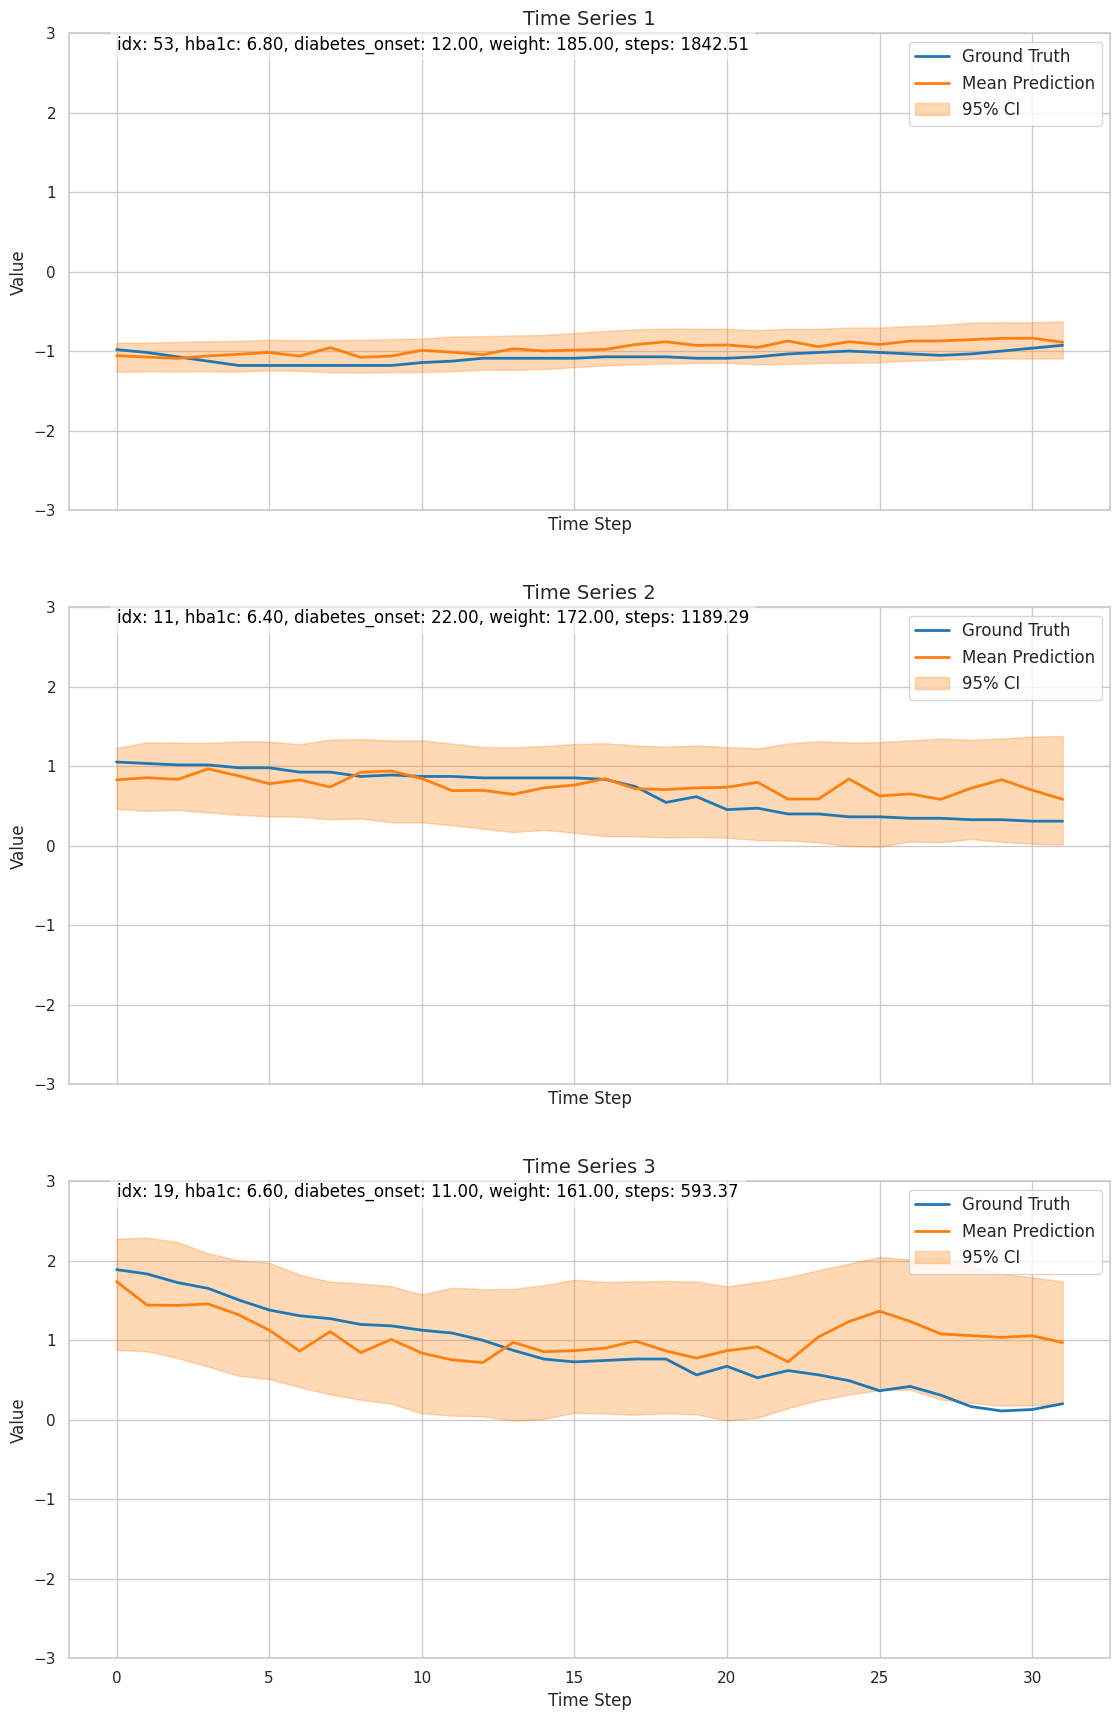

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.ndimage import uniform_filter1d
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Setting the Seaborn style
sns.set(style="whitegrid")

def plot_time_series_with_ci(groundtruth, sampled_output, cov, batch_x = None, num_series=5):
    fig, axes = plt.subplots(num_series, 1, figsize=(12, 6*num_series), sharex=True)
    if num_series == 1:
        axes = [axes]
    idx_list = [53, 11, 19]
    for i in range(num_series):
        # Randomly select a time series from the batch
        idx = idx_list[i]
        hba1c = cov.feat_dict[stype.numerical][idx, 3]
        diabetes_onset = cov.feat_dict[stype.numerical][idx, 1]
        weight = cov.feat_dict[stype.numerical][idx, 4]
        
        if batch_x is not None:
            hr = batch_x[idx, :, 0] * 20.41707644 + 7.93461185e+01
            steps = batch_x[idx, :, 1] * 20.84327263 +  6.53019535e+00
            print(steps) 
            hr_mean = np.mean(hr.cpu().numpy())
            steps_mean = np.sum(steps.cpu().numpy())
        # Plot ground truth
        axes[i].plot(groundtruth[idx, :, 0], color='#1f77b4', label='Ground Truth', lw=2)
        
        # Add textual information
        axes[i].text(0, 2.8, f'idx: {idx}, hba1c: {hba1c.cpu().numpy():.2f}, diabetes_onset: {diabetes_onset.cpu().numpy():.2f}, weight: {weight.cpu().numpy():.2f}, steps: {steps_mean:.2f}', 
                     fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
        
        # Calculate mean and confidence interval
        mean = np.mean(sampled_output[idx, :, :, 0], axis=0)
        ci_lower = np.percentile(sampled_output[idx, :, :, 0], 80, axis=0)
        ci_upper = np.percentile(sampled_output[idx, :, :, 0], 20, axis=0)
        
        # Smooth the CI with a moving average
        ci_lower_smooth = uniform_filter1d(ci_lower, size=5)
        ci_upper_smooth = uniform_filter1d(ci_upper, size=5)
        
        # Plot mean prediction
        axes[i].plot(mean, color='#ff7f0e', label='Mean Prediction', lw=2)
        
        # Plot confidence interval
        axes[i].fill_between(range(mean.shape[0]), ci_lower_smooth, ci_upper_smooth, color='#ff7f0e', alpha=0.3, label='95% CI')
        
        axes[i].set_title(f'Time Series {i+1}', fontsize=14)
        axes[i].set_xlabel('Time Step', fontsize=12)
        axes[i].set_ylabel('Value', fontsize=12)
        
        # Set y limit to be the same for all plots
        axes[i].set_ylim([-3, 3])
        axes[i].legend(loc='upper right', fontsize=12)
    
    plt.tight_layout(pad=3.0)
    plt.savefig('time_series_with_ci.pdf')
    plt.show()

# Sample invocation of the function with your data
# plot_time_series_with_ci(groundtruth, sampled_output, cov, num_series=5)


groundtruth = model.sample_outputs[0]['true']
sampled_output = model.sample_outputs[0]['pred']
cov = model.sample_outputs[0]['batch_cov']
batch_x = model.sample_outputs[0]['batch_x']
# Call the function to plot 2 random time series
plot_time_series_with_ci(groundtruth, sampled_output, cov, batch_x, num_series=3)

In [30]:
batch_x

tensor([[[ 1.2891,  5.0049, -0.0521,  0.6001],
         [ 1.6402,  4.5506, -0.0521,  0.4732],
         [ 1.4361,  5.2279, -0.0521,  0.2374],
         ...,
         [-1.0210, -0.3133, -0.0521, -1.1229],
         [-1.0373, -0.3133, -0.0521, -1.1592],
         [-0.8578, -0.3133, -0.0521, -1.1592]],

        [[ 1.5912, -0.3133, -0.0521, -0.5425],
         [ 0.8157, -0.3114, -0.0521, -0.2523],
         [ 0.4320, -0.3133, -0.0521, -0.1072],
         ...,
         [ 0.2524,  1.8000, -0.0521,  2.1237],
         [-0.0578, -0.3133, -0.0521,  1.8335],
         [ 0.4483, -0.3133, -0.0521,  1.5070]],

        [[ 0.0647, -0.3133, -0.0521,  4.6448],
         [ 0.0239, -0.3133, -0.0521,  4.6448],
         [ 0.3259,  1.0338, -0.0521,  4.6448],
         ...,
         [-1.4047, -0.3133, -0.0521, -0.1072],
         [-0.7843, -0.3133, -0.0521, -0.1616],
         [-1.3884, -0.3133, -0.0521, -0.2342]],

        ...,

        [[-0.2863, -0.3133, -0.0521,  2.8129],
         [-0.3598, -0.3133, -0.0521,  2.8129]